In [2]:
import os
import pandas as pd

# Function to parse data from a single file
def parse_file(file_path):
    data = []
    date = os.path.basename(file_path).split('.')[0]  # Extract date from filename
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 10:
                time = parts[0]
                am_pm = parts[1]
                temp = parts[2]
                dew_point = parts[4]
                humidity = parts[6]
                wind_speed = parts[9]
                
                # Check if 'temp', 'dew_point', 'humidity', and 'wind_speed' are digits
                if temp.isdigit() and dew_point.isdigit() and humidity.isdigit() and wind_speed.isdigit():
                    data.append([date, time, am_pm, int(temp), int(dew_point), int(humidity), int(wind_speed)])
                    
    return data

# Function to process data for a city and return the DataFrame
def process_city_data(folder_path):
    all_data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            all_data.extend(parse_file(file_path))
    df = pd.DataFrame(all_data, columns=['date', 'time', 'am/pm', 'temp', 'dew_point', 'humidity', 'wind_speed'])
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'] + ' ' + df['am/pm'], format='%Y-%m-%d %I:%M %p')
    df.drop(['date', 'time', 'am/pm'], axis=1, inplace=True)
    df.sort_values(by='datetime', inplace=True)
    return df

# Folder paths for different cities
folder_paths = {
    'nyc': '/Users/samdvorin/Desktop/code/542/weather-prediction/nyc_weather_data',
    'chi': '/Users/samdvorin/Desktop/code/542/weather-prediction/chi_weather_data',
    'mia': '/Users/samdvorin/Desktop/code/542/weather-prediction/miami_weather_data',
    'aus': '/Users/samdvorin/Desktop/code/542/weather-prediction/austin_weather_data'
}

# Dictionary to store DataFrames for each city
city_dfs = {}

# Process data for each city and store the DataFrame
for city, folder_path in folder_paths.items():
    city_dfs[city] = process_city_data(folder_path)

# Example usage: Print the first few rows of NYC DataFrame
print(city_dfs['nyc'].head())
print(city_dfs['chi'].head())
print(city_dfs['mia'].head())
print(city_dfs['aus'].head())


     temp  dew_point  humidity  wind_speed            datetime
228    46         32        58           5 2024-02-01 00:51:00
202    39         30        70           0 2024-02-01 01:46:00
203    40         30        68           0 2024-02-01 01:51:00
204    39         30        70           5 2024-02-01 02:46:00
205    40         29        65           6 2024-02-01 02:51:00
     temp  dew_point  humidity  wind_speed            datetime
212    39         34        82          13 2024-02-01 00:53:00
186    37         33        86           8 2024-02-01 01:53:00
187    37         33        86           9 2024-02-01 02:53:00
188    36         32        86           9 2024-02-01 03:53:00
189    37         33        86          10 2024-02-01 04:53:00
     temp  dew_point  humidity  wind_speed            datetime
164    64         47        54           0 2024-02-01 00:53:00
141    61         52        72           8 2024-02-01 01:53:00
142    59         50        72           5 2024-02-01 0

Mean Squared Error: 17.856735340892854


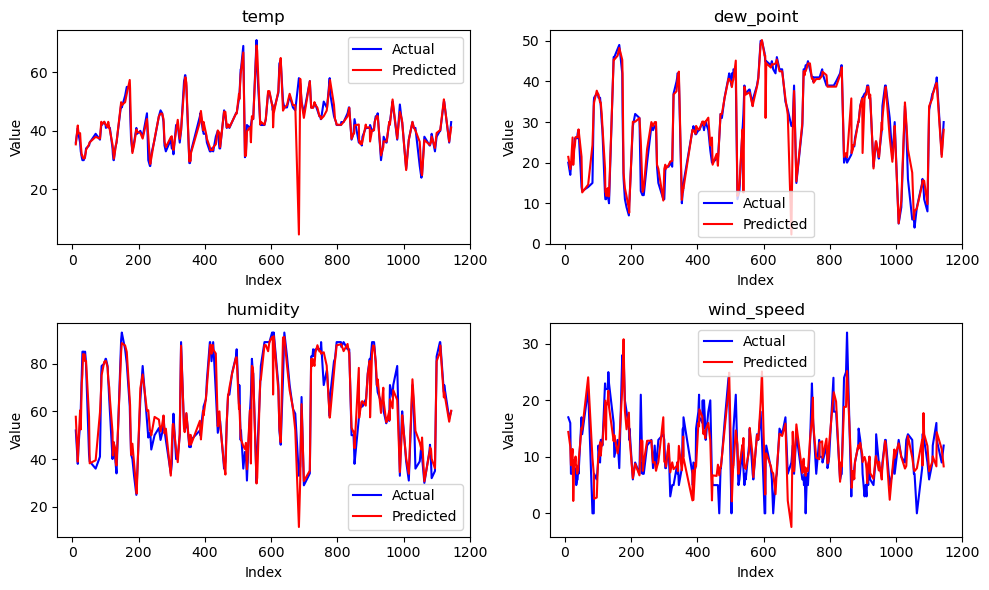

In [20]:
''' 

Trying to work more on state consideration

'''

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = city_dfs['nyc'].copy()
# First, let's convert the datetime column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Next, let's create lag features for each variable
lag_features = ['temp', 'dew_point', 'humidity', 'wind_speed']
num_lags = 1  # You can adjust this value based on how many previous states you want to consider

for feature in lag_features:
    for i in range(1, num_lags + 1):
        df[f'{feature}_lag_{i}'] = df[feature].shift(i)

# Drop rows with NaN resulting from shifting
df.dropna(inplace=True)

# Split the data into features (X) and target variable (y)
X = df.drop(['temp', 'dew_point', 'humidity', 'wind_speed', 'datetime'], axis=1)
y = df[['temp', 'dew_point', 'humidity', 'wind_speed']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model with feature names
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Sort the test data by datetime for plotting
sorted_indices = y_test.index.argsort()
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Plot actual vs predicted values for each variable
plt.figure(figsize=(10, 6))

for i, feature in enumerate(['temp', 'dew_point', 'humidity', 'wind_speed']):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_sorted.index, y_test_sorted[feature], label='Actual', color='blue')
    plt.plot(y_test_sorted.index, y_pred_sorted[:, i], label='Predicted', color='red')
    plt.title(feature)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()





In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Assuming city_dfs is a dictionary containing dataframes for each city
# Combine data from all cities into one dataframe
combined_df = pd.concat(city_dfs.values())

# Function to shift the target variables to align with features
def shift_target(df, target_cols, shift_by=1):
    df_targets = df[target_cols].shift(-shift_by)
    df_targets.columns = [col + '_next' for col in target_cols]
    return pd.concat([df, df_targets], axis=1)

#print(combined_df.head())
# Define the target columns
target_cols = ['temp', 'dew_point', 'humidity', 'wind_speed']

# Shift the target variables to align with features
combined_df = shift_target(combined_df, target_cols)

# Drop rows with NaN values (last rows will have NaN as we shifted the target)
combined_df = combined_df.dropna()

# Separate features and target variable
X = combined_df.drop(columns=[col+'_next' for col in target_cols] + ['datetime'])
y = combined_df[[col+'_next' for col in target_cols]]

# Define hyperparameters to search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best estimator from the search
best_model = random_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your predictive model (example using RandomForestRegressor)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate your model
score = model.score(X_test, y_test)
print("Model Score:", score)


Mean Squared Error: 22.594797594742495
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
Model Score: 0.8215174720995695


In [28]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate the model with the best hyperparameters
new_model = RandomForestRegressor(n_estimators=100,
                                  min_samples_split=2,
                                  min_samples_leaf=4,
                                  max_features='auto',
                                  max_depth=20,
                                  bootstrap=True,
                                  random_state=42)

# Train the new model
new_model.fit(X_train, y_train)

# Make predictions
y_pred_new = new_model.predict(X_test)

# Evaluate the new model
mse_new = mean_squared_error(y_test, y_pred_new)
print("Mean Squared Error (New Model):", mse_new)

# Evaluate the new model's score
score_new = new_model.score(X_test, y_test)
print("Model Score (New Model):", score_new)


Mean Squared Error (New Model): 22.544241834057914
Model Score (New Model): 0.8432330814980941


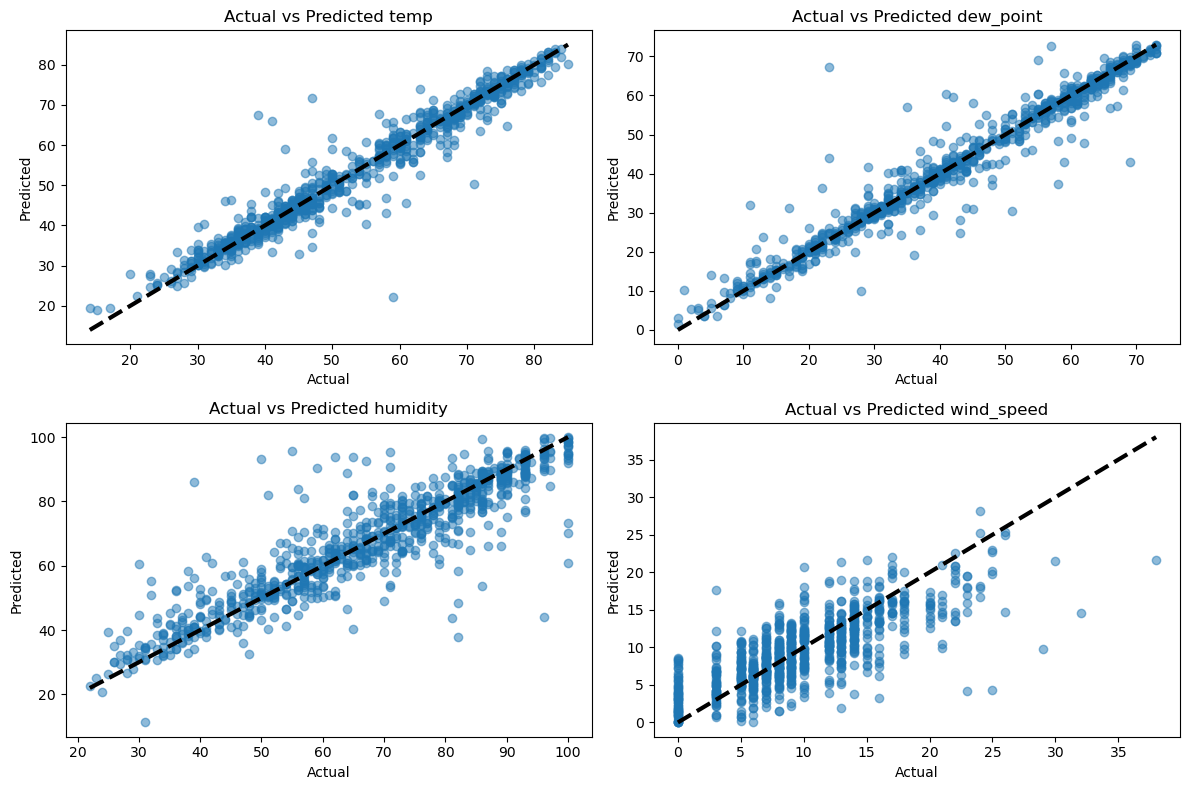

In [29]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot actual vs predicted for each target variable
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    target_col = target_cols[i]
    ax.scatter(y_test[target_col+'_next'], y_pred[:, i], alpha=0.5)
    ax.plot([y_test[target_col+'_next'].min(), y_test[target_col+'_next'].max()], 
            [y_test[target_col+'_next'].min(), y_test[target_col+'_next'].max()], 'k--', lw=3)
    ax.set_title(f'Actual vs Predicted {target_col}')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

plt.tight_layout()
plt.show()

In [31]:
import numpy as np
import pandas as pd

def extend_predictions(model, initial_data, num_hours):
    """
    Function to extend predictions of the four parameters (temp, dew_point, humidity, wind_speed)
    at an hourly frequency based on the initial data using the specified model.

    Parameters:
    - model: Trained regression model capable of making predictions.
    - initial_data: DataFrame containing the initial data with columns ['temp', 'dew_point', 'humidity', 'wind_speed'].
    - num_hours: Number of hours to extend the predictions.

    Returns:
    - extended_data: Extended DataFrame containing the predicted values.
    """

    # Copy the initial data to work with
    extended_data = initial_data.copy()

    # Set the initial datetime and the datetime increment
    current_datetime = initial_data['datetime'].max()
    datetime_increment = pd.Timedelta(hours=1)

    # Loop to predict and extend data
    for i in range(num_hours):
        # Prepare features for prediction (use the last row of extended_data)
        features = extended_data[['temp', 'dew_point', 'humidity', 'wind_speed']].tail(1)

        # Make prediction for the next hour
        next_prediction = model.predict(features)

        # Create a new row with the predicted values and updated datetime
        next_datetime = current_datetime + datetime_increment
        new_row = pd.DataFrame({'temp': next_prediction[0][0],
                                'dew_point': next_prediction[0][1],
                                'humidity': next_prediction[0][2],
                                'wind_speed': next_prediction[0][3],
                                'datetime': next_datetime}, index=[0])

        # Append the new row to the extended_data DataFrame
        extended_data = pd.concat([extended_data, new_row], ignore_index=True)


        # Update current_datetime for the next iteration
        current_datetime = next_datetime

    return extended_data

# Example usage:
# Assuming 'model' is your trained RandomForestRegressor model and 'initial_data' is your initial DataFrame
extended_data = extend_predictions(model, city_dfs['nyc'], num_hours=24)

# Print the extended data
print(extended_data)


           temp  dew_point   humidity  wind_speed            datetime
0     46.000000    32.0000  58.000000    5.000000 2024-02-01 00:51:00
1     39.000000    30.0000  70.000000    0.000000 2024-02-01 01:46:00
2     40.000000    30.0000  68.000000    0.000000 2024-02-01 01:51:00
3     39.000000    30.0000  70.000000    5.000000 2024-02-01 02:46:00
4     40.000000    29.0000  65.000000    6.000000 2024-02-01 02:51:00
...         ...        ...        ...         ...                 ...
1177  65.018000    48.4200  56.164000    6.390000 2024-03-16 11:51:00
1178  62.903333    49.2325  61.219167    6.978333 2024-03-16 12:51:00
1179  66.168000    49.1400  54.974000    7.880000 2024-03-16 13:51:00
1180  65.960000    49.7800  56.110000    8.520000 2024-03-16 14:51:00
1181  65.420000    50.2800  57.800000   10.000000 2024-03-16 15:51:00

[1182 rows x 5 columns]


/var/folders/mf/txv8p7fx2yz68v4bx9pfbxf80000gn/T/ipykernel_11783/3068439286.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_data = extended_data.append(new_row, ignore_index=True)
/var/folders/mf/txv8p7fx2yz68v4bx9pfbxf80000gn/T/ipykernel_11783/3068439286.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_data = extended_data.append(new_row, ignore_index=True)
/var/folders/mf/txv8p7fx2yz68v4bx9pfbxf80000gn/T/ipykernel_11783/3068439286.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_data = extended_data.append(new_row, ignore_index=True)
/var/folders/mf/txv8p7fx2yz68v4bx9pfbxf80000gn/T/ipykernel_11783/3068439286.py:42: FutureWarning: The frame.append method is deprecated and will be rem